In [1]:
import pystac_client
import planetary_computer as pc

import os
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

In [2]:
import iceplant_detection_functions as ipf

In [4]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


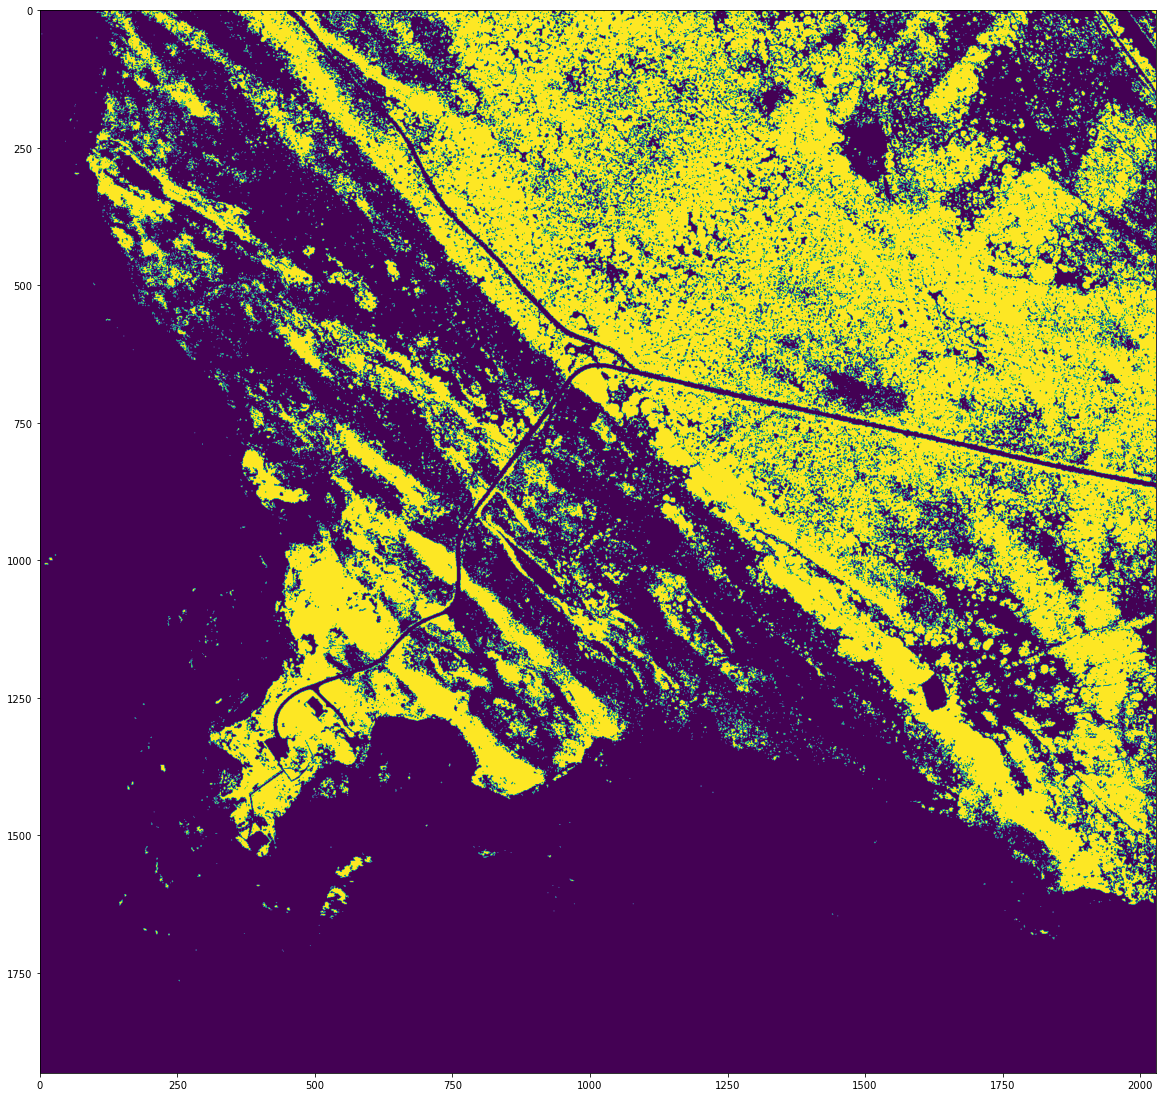

In [6]:
dgm = aois.iloc[4]  # Campus Lagoon aoi

dangermond = ipf.select_ndvi_image(dgm.itemid, dgm.geometry)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(dangermond)
plt.show()

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


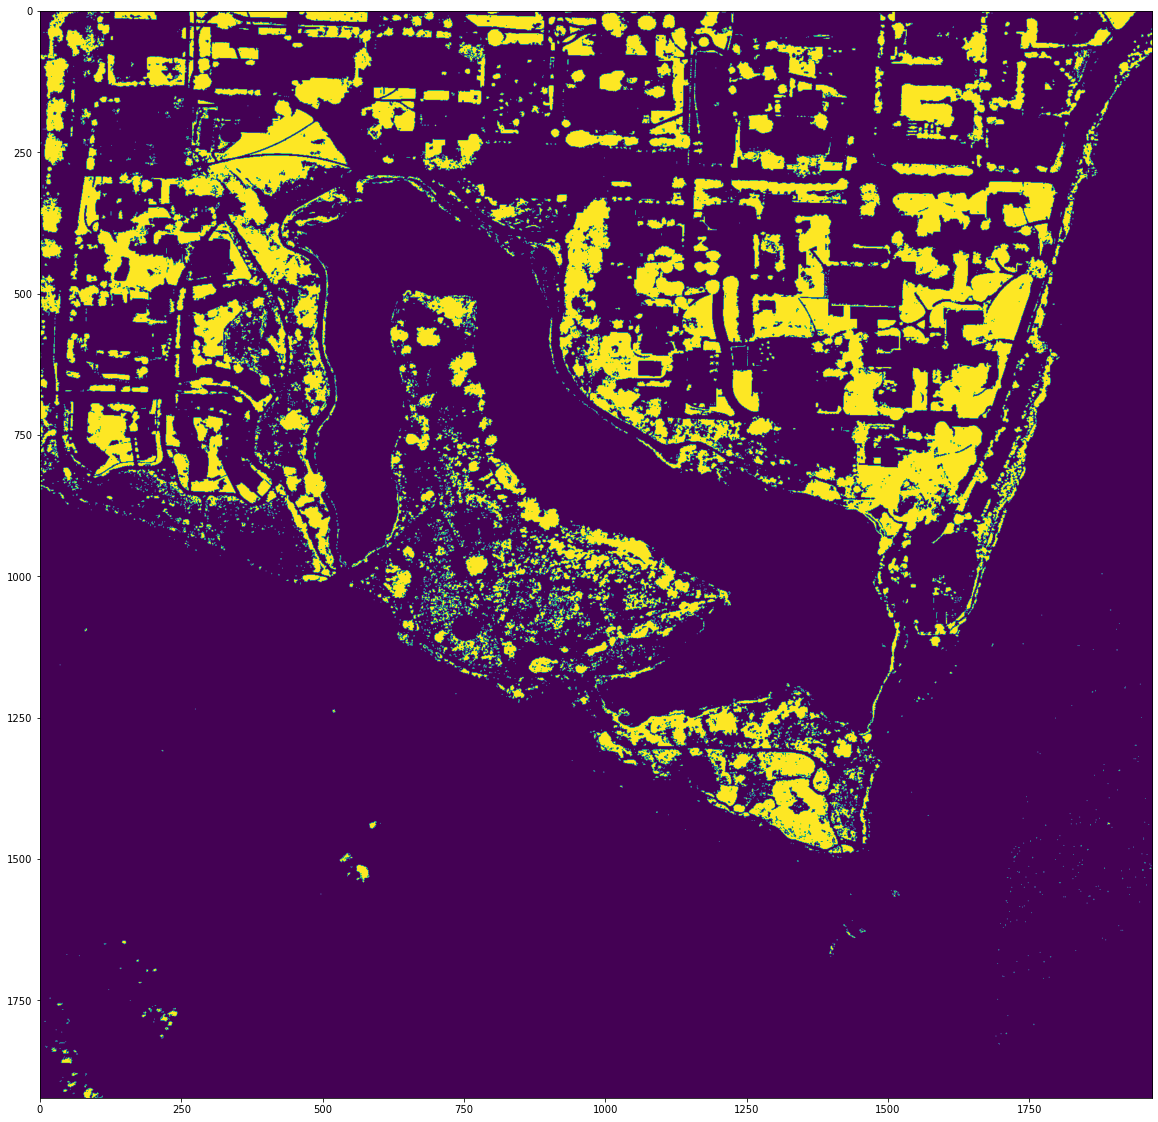

In [5]:
cp = aois.iloc[0]  # Campus Lagoon aoi

campus_point = ipf.select_ndvi_image(cp.itemid,cp.geometry)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(campus_point)
plt.show()

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


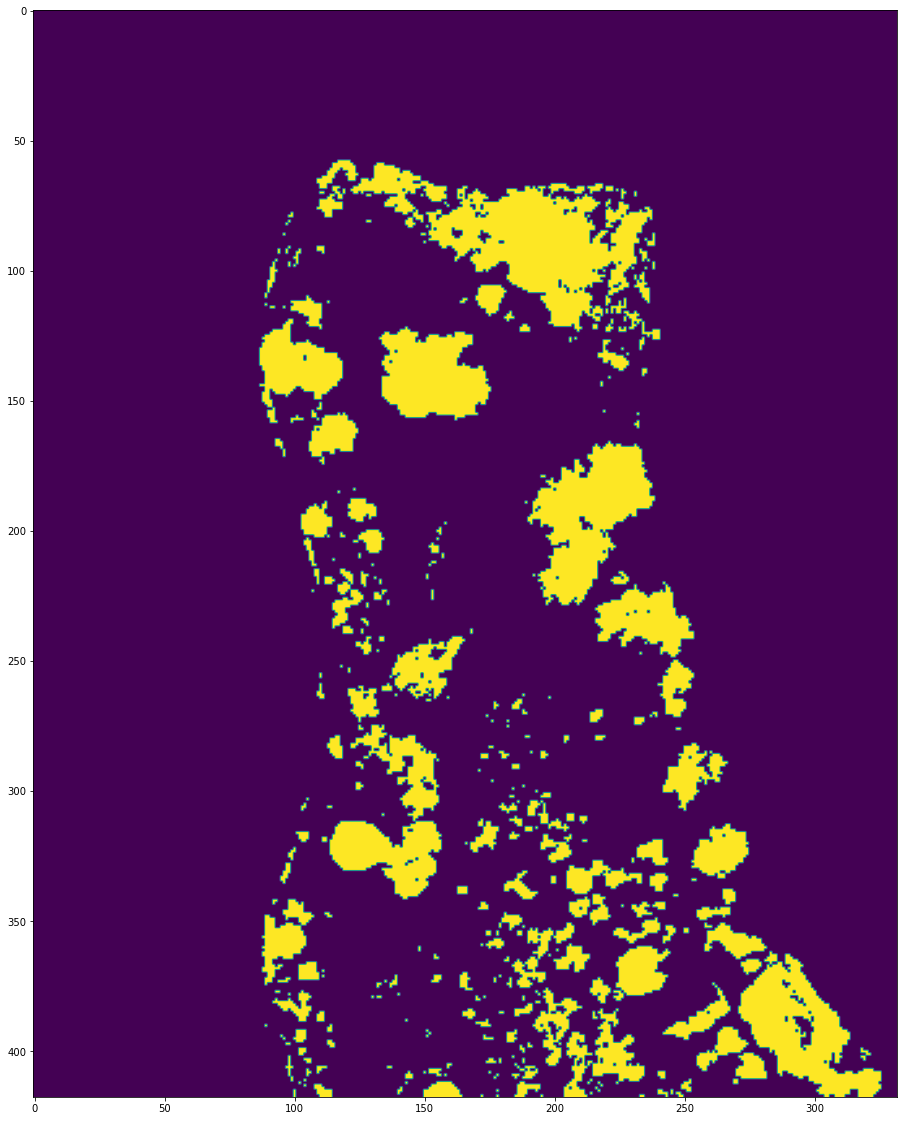

In [6]:
lagoon_zoom = ipf.select_ndvi_image(aois.iloc[1].itemid,aois.iloc[1].geometry)

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(lagoon_zoom)
plt.show()



/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


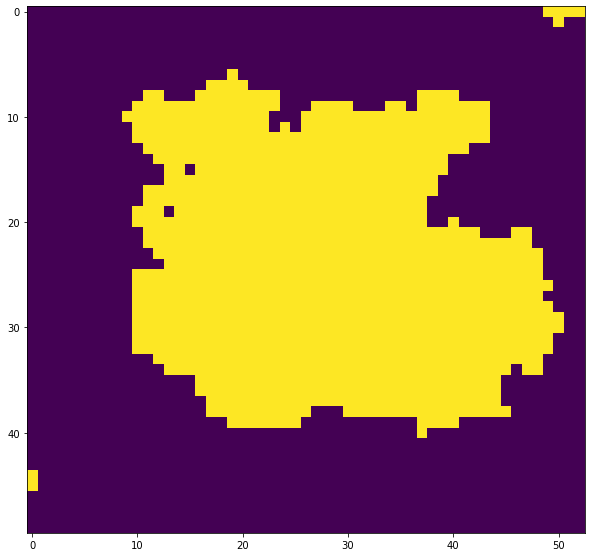

In [5]:
tree = ipf.select_ndvi_image(aois.iloc[2].itemid,aois.iloc[2].geometry)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(tree)
plt.show()

